**<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/applying_a_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>**

# Applying a pretrained pipeline

In this tutorial, you will learn how to apply `pyannote.audio` pipelines on an audio file.

A pipeline takes an audio file as input and returns a labeled temporal segmentation of the audio file.

More precisely, it usually applies a pretrained model (= neural network) on the audio file, post-processes the output of the model, and returns its output as a [`pyannote.core.Annotation`](http://pyannote.github.io/pyannote-core/structure.html#annotation) instance. It should become clearer as you keep reading...

## Tutorial setup

### `Google Colab` setup


If you are running this tutorial on `Colab`, execute the following commands in order to setup `Colab` environment. These commands will install `pyannote.audio`, and download resources used in this tutorial.

In [4]:
!pip install -qq pyannote.audio==3.1.1
!pip install -qq ipython==7.34.0
!wget -q "https://github.com/pyannote/pyannote-audio/raw/develop/tutorials/assets/sample.wav"
!wget -q "https://github.com/pyannote/pyannote-audio/raw/develop/tutorials/assets/sample.rttm"
!wget -q -P ./assets/ "https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/assets/download-model.png"
!wget -q -P ./assets/ "https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/assets/download-pipeline.png"

⚠ Restart the runtime (Runtime > Restart session).

In [13]:
AUDIO_FILE = "sample.wav"
REFERENCE = "sample.rttm"

### Non `Google Colab` setup

If you are not using Colab, clone `pyannote.audio` [GitHub repository](https://github.com/pyannote/pyannote-audio) and update ROOT_DIR accordingly

In [10]:
ROOT_DIR = "<path-to-pyannote-github-repo>/pyannote-audio"
AUDIO_FILE = f"{ROOT_DIR}/tutorials/assets/sample.wav"
REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"

## Loading pipeline from 🤗 hub

A bunch of pretrained pipelines are available on [🤗 Huggingface model hub](https://hf.co/models?other=pyannote-audio-pipeline) and can be listed by looking for the [`pyannote-audio-pipeline`](https://hf.co/models?other=pyannote-audio-pipeline) tag.

In [2]:
from huggingface_hub import HfApi
available_pipelines = [p.modelId for p in HfApi().list_models(filter="pyannote-audio-pipeline")]
list(filter(lambda p: p.startswith("pyannote/"), available_pipelines))

['pyannote/overlapped-speech-detection',
 'pyannote/speaker-diarization',
 'pyannote/speaker-segmentation',
 'pyannote/voice-activity-detection',
 'pyannote/speaker-diarization-3.0',
 'pyannote/speaker-diarization-3.1']

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters. Despite this initial process, those pipelines can perfectly be downloaded for later offline use: keep reading this tutorial until the end to learn how to do that.

For instance, to load the speaker diarization pipeline used in this tutorial, you have to visit [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization), accept the terms, visit [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation) (used internally by the speaker diarization pipeline), accept the terms, and log in using `notebook_login` below:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Once authenticated, you can load the pipeline (and the internal models)...

In [ ]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True)

## Processing a file from disk

... and apply it to an audio file.  

The pipeline will automatically use GPUs when available.
On CPU it might take a long while (up to 10x RT).

In [9]:
dia = pipeline(AUDIO_FILE)

## Visualizing the output

Most pipelines return a [`pyannote.core.Annotation`](http://pyannote.github.io/pyannote-core/structure.html#annotation) instance...

In [10]:
from pyannote.core import Annotation
assert isinstance(dia, Annotation)

... whose [API](https://pyannote.github.io/pyannote-core/structure.html#annotation) you can use to print the result:

In [11]:
for speech_turn, track, speaker in dia.itertracks(yield_label=True):
    print(f"{speech_turn.start:4.1f} {speech_turn.end:4.1f} {speaker}")

 6.7  7.2 SPEAKER_01
 7.2  7.2 SPEAKER_02
 7.6  8.3 SPEAKER_01
 8.3  9.9 SPEAKER_02
 9.9 10.9 SPEAKER_01
10.5 14.7 SPEAKER_02
10.9 11.0 SPEAKER_00
14.3 17.9 SPEAKER_00
18.0 21.5 SPEAKER_02
18.2 18.4 SPEAKER_00
21.8 28.5 SPEAKER_00
27.9 30.0 SPEAKER_02


If you happen to be running this example in a _Jupyter notebook_, `dia` can be [visualized directly](http://pyannote.github.io/pyannote-core/visualization.html):

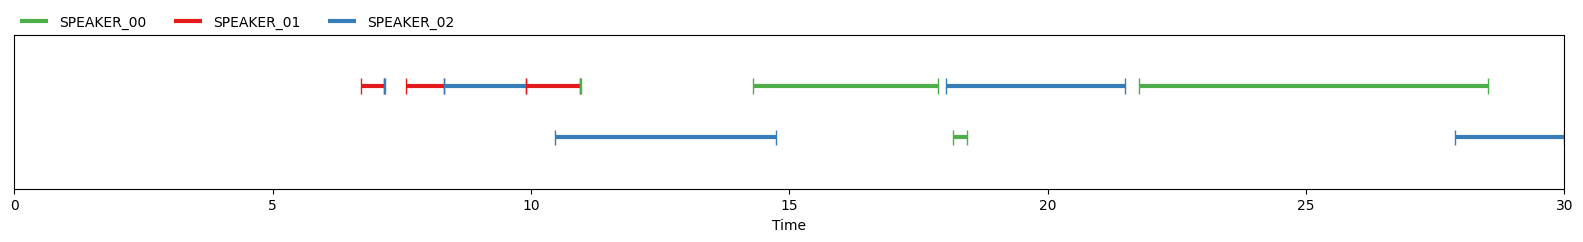

In [12]:
# we visualize [0, 30] time range
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)
dia

When available, the reference annotation can be visualized too, for comparison:

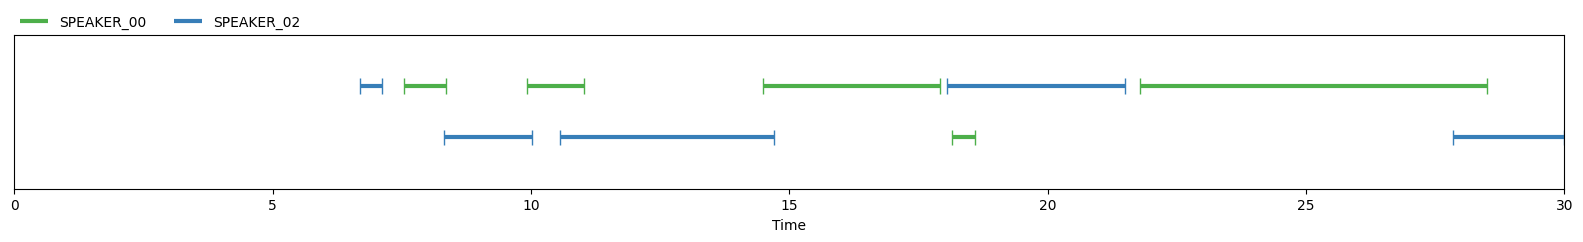

In [14]:
from pyannote.database.util import load_rttm

reference = load_rttm(REFERENCE)["sample"]

# map hypothesized and reference speakers for visualization purposes
pipeline.optimal_mapping(dia, reference)

## Processing a file from memory

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary.

In [11]:
import torchaudio
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


In [ ]:
vad = Pipeline.from_pretrained("pyannote/voice-activity-detection", use_auth_token=True)

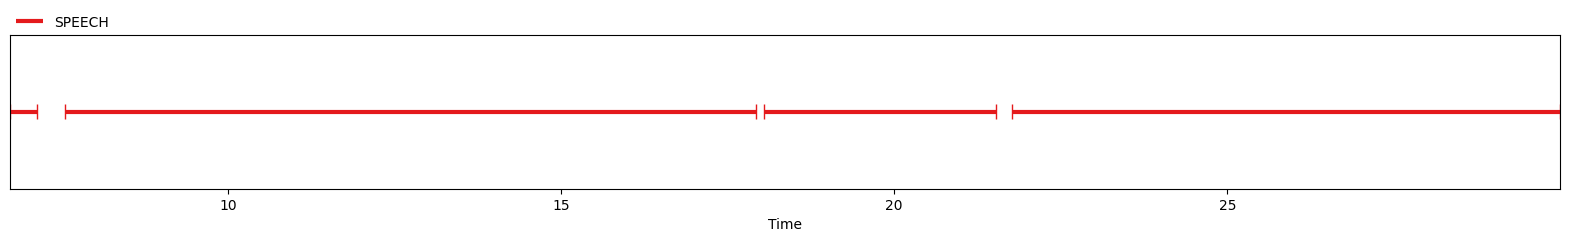

In [12]:
vad(audio_in_memory)

## Offline use

Gating models and pipelines allows [me](https://herve.niderb.fr) to know a bit more about `pyannote.audio` user base and eventually help me write grant proposals to make `pyannote.audio` even better. Please fill this form as precisely as possible.

For instance, before gating `pyannote/speaker-diarization`, I had no idea that so many people were relying on it in production. Hint: sponsors are more than welcome! maintaining open source libraries is time consuming.

That being said: this whole authentication process does not prevent you from using official `pyannote.audio` models and pipelines offline (i.e. without going through the authentication process in every `docker run ...` or whatever you are using in production).

* Step 1: download `config.yaml` of [`pyannote/voice-activity-detection`](https://hf.co/pyannote/voice-activity-detection) pipeline

![](https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/assets/download-pipeline.png?raw=1)

* Step 2: download the `pytorch_model.bin` model

![](https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/assets/download-model.png?raw=1)

* Step 3: edit `config.yaml` to point to the local model

```diff
pipeline:
  name: pyannote.audio.pipelines.VoiceActivityDetection
  params:
-    segmentation: pyannote/segmentation@Interspeech2021
+    segmentation: pytorch_model.bin

params:
  min_duration_off: 0.09791355693027545
  min_duration_on: 0.05537587440407595
  offset: 0.4806866463041527
  onset: 0.8104268538848918
```

* Step 4: load the pipeline

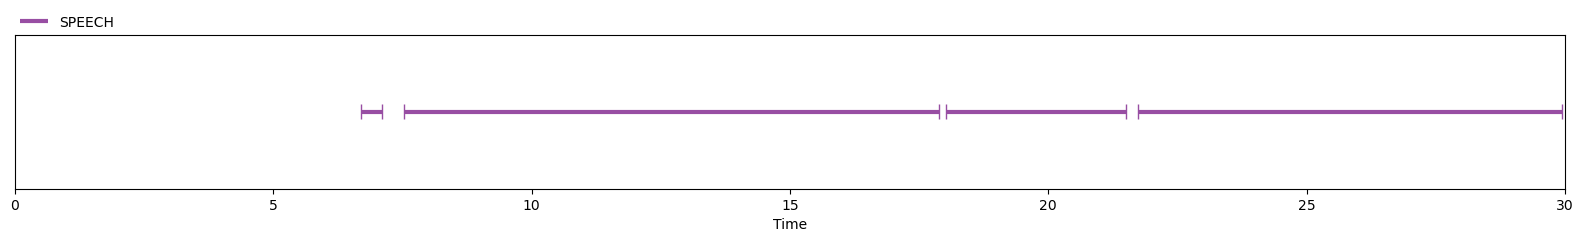

In [ ]:
# look ma: no hands!
offline_vad = Pipeline.from_pretrained("config.yaml")
offline_vad(audio_in_memory)

In [ ]:
# just checking output is the same
assert (vad(audio_in_memory) == offline_vad(audio_in_memory))